<a href="https://colab.research.google.com/github/evillag/uncertainty_gan/blob/main/CERN_UE_Uncertainty_Scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import gaussian_kde

Importing sample data for training and testing. Refer to `[Feature_Densities]_CERN_uncertainties.ipynb` for implementation.

In [2]:
dir = 'drive/MyDrive/Colab Notebooks/pion_predictions/'

pion_predictions_train = np.load(dir + 'pion_predictions_train.npy')
pion_predictions_test = np.load(dir + 'pion_predictions_test.npy')

print('Training data shape:', pion_predictions_train.shape)
print('Test data shape:', pion_predictions_test.shape)

Training data shape: (947947, 128)
Test data shape: (524521, 128)


# Toy example

1. Generate a $\mathcal{N}(0,1)$ distribution.
2. Estimate its density through KDE.
3. Compute the likelihood of several points as their evaluation in the KDE.

**Expected result:** The likelihoods decrease as the evaluation points grow further apart from 0.

Likelihood of 0 in KDE: 0.3907810005534111
Likelihood of 1 in KDE: 0.24935521872720373
Likelihood of 2 in KDE: 0.05599437152318374
Likelihood of 3 in KDE: 0.002718877666291957


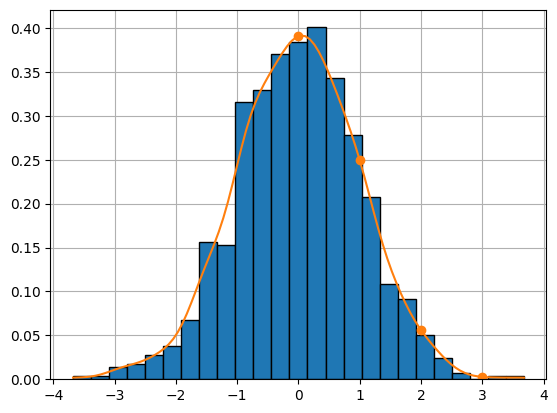

In [3]:
data = np.random.normal(0, 1, 1000)
kde = gaussian_kde(data)

points = 0, 1, 2, 3
likelihoods = kde(points)

for point, likelihood in zip(points, likelihoods):
  print(f'Likelihood of {point} in KDE: {likelihood}')

x = np.linspace(data.min(), data.max(), 100)

plt.gca().set_axisbelow(True)
plt.grid()
plt.hist(data, 25, density=True, edgecolor='black')
plt.plot(x, kde(x))
plt.scatter(points, likelihoods, color='tab:orange')
plt.show()

# Results

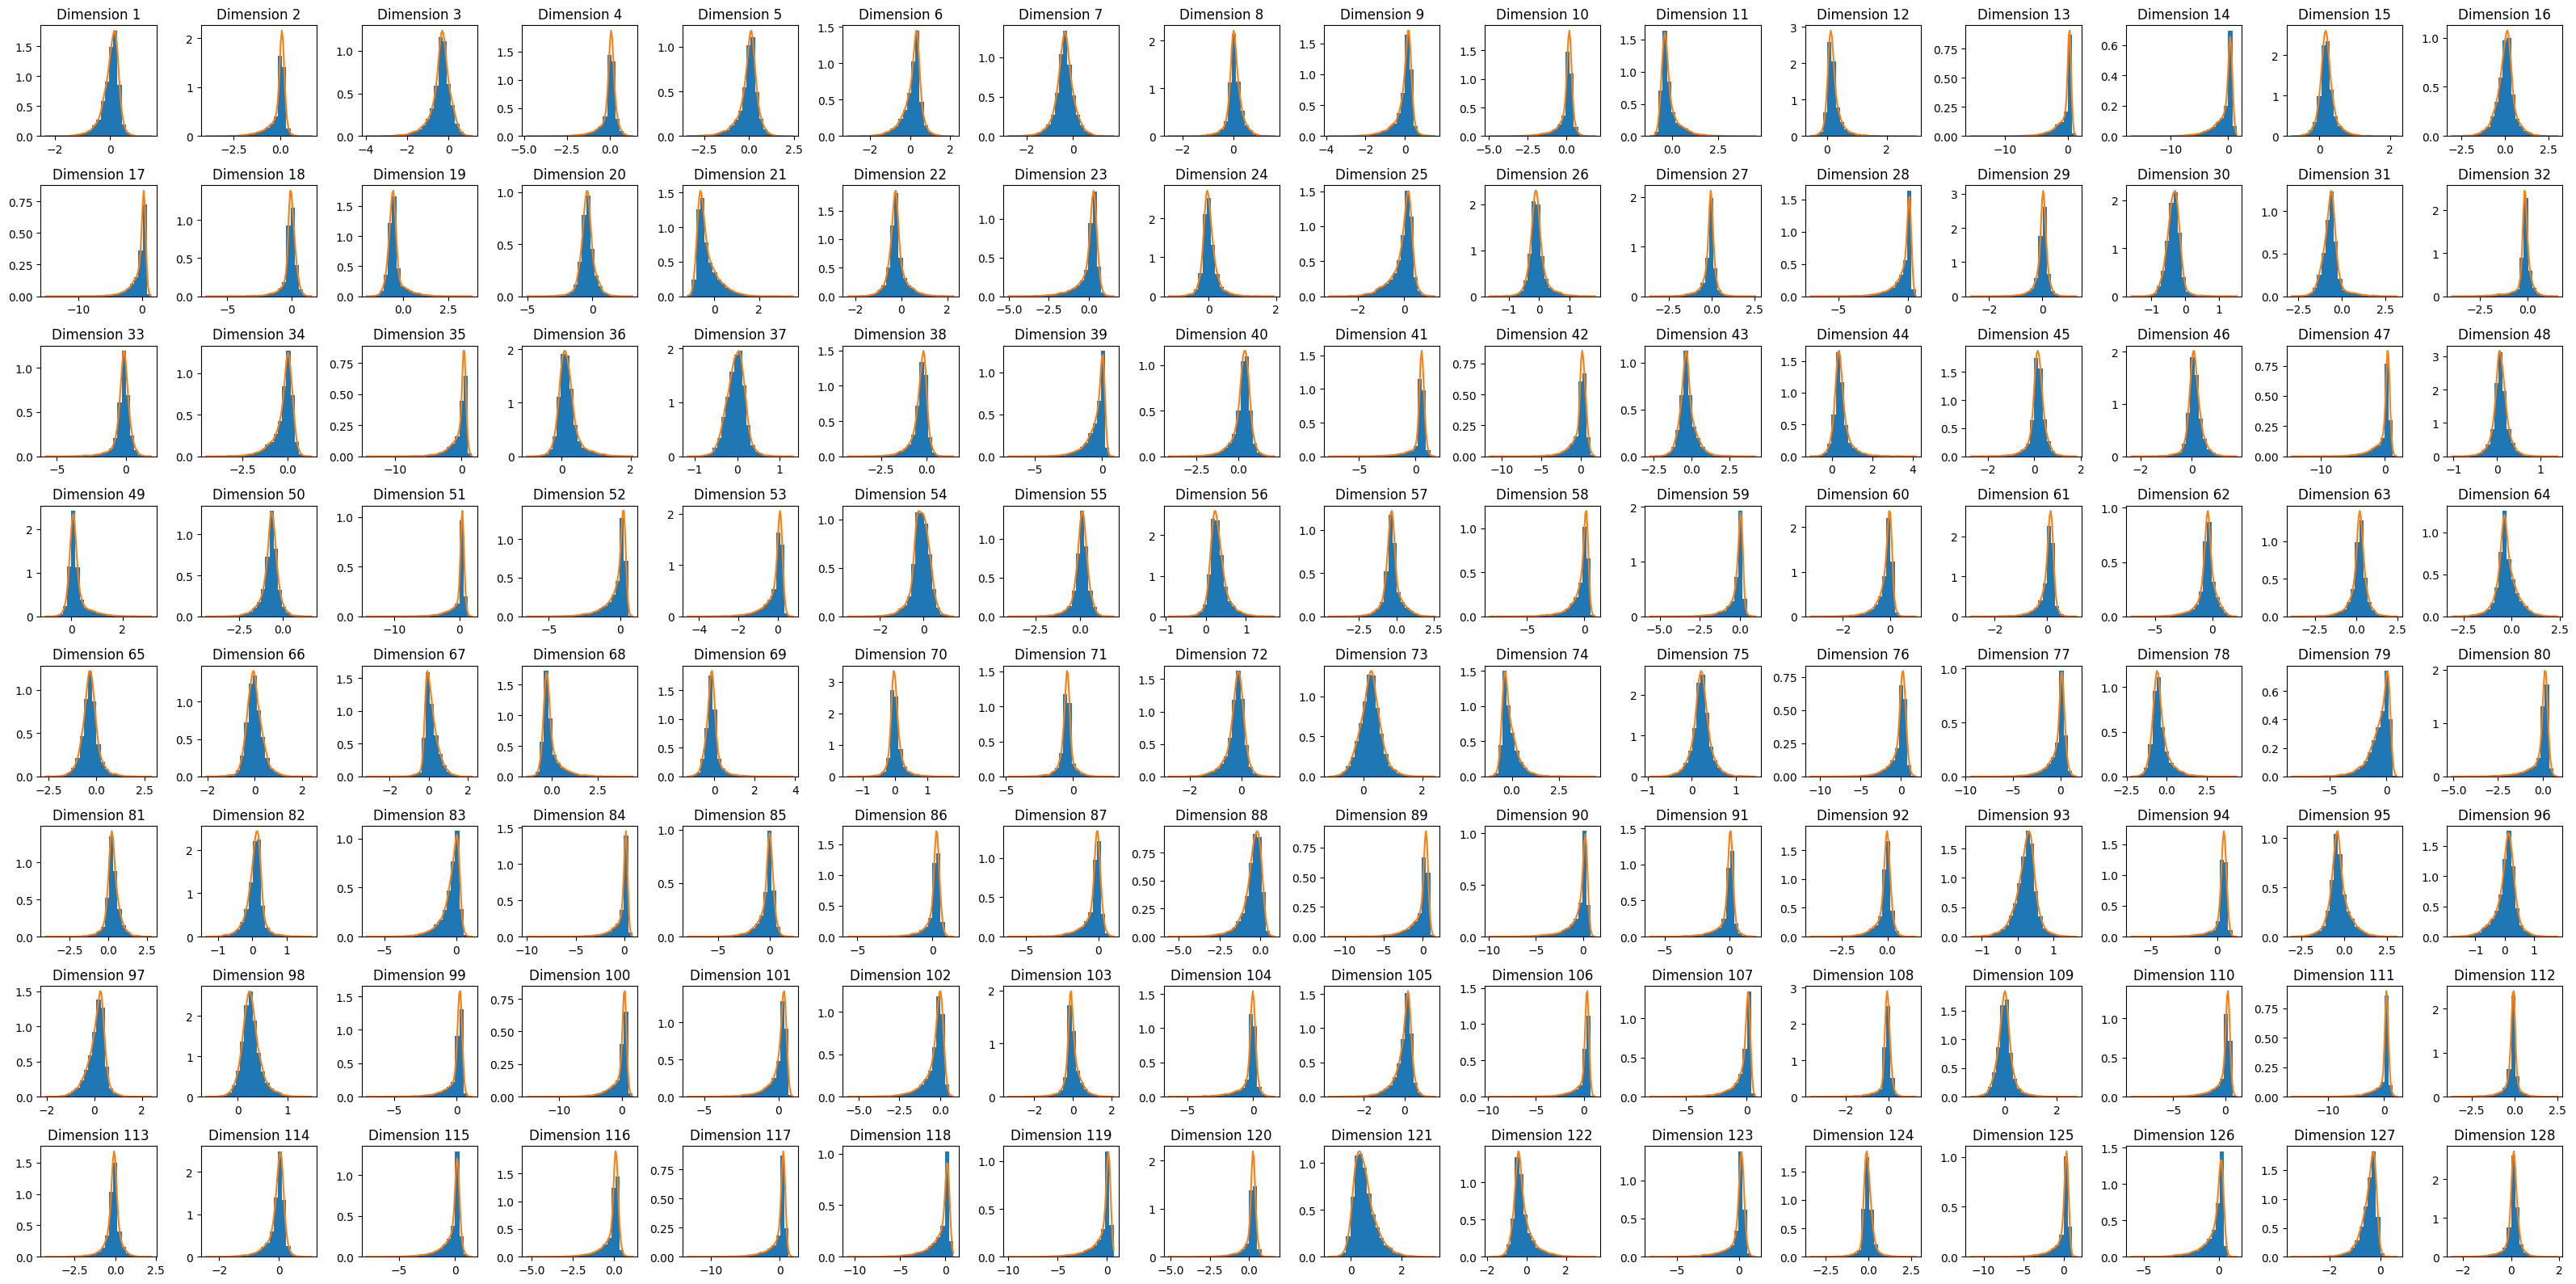

In [4]:
def plot_hist_kde(ax, i, data, kde):
  x = np.linspace(data.min(), data.max(), 100)
  ax.set_title(f'Dimension {i + 1}')
  ax.hist(data, 25, density=True)
  ax.plot(x, kde(x))

def estimate_likelihoods(train_data, test_data, n_samples=None, n_features=None, plot_shape=None):
  if not n_samples:
    n_samples = test_data.shape[0] # 524521 observations

  if not n_features:
    n_features = train_data.shape[1] # 128 dimensions

  n_subplots = plot_shape[0] * plot_shape[1]

  if n_features != n_subplots:
    raise ValueError(f'Cannot plot {n_features} features in {n_subplots} subplots.')

  likelihoods = np.zeros((n_samples, n_features))

  if plot_shape:
    rows, columns = plot_shape
    fig, axes = plt.subplots(rows, columns, figsize=(2 * columns, 2 * rows))

  for i in range(n_features):
    train_sample = train_data[:10000, i]
    kde = gaussian_kde(train_sample)

    test_sample = test_data[:n_samples, i]
    likelihoods[:, i] = kde(test_sample)

    if plot_shape:
      plot_hist_kde(axes.flat[i], i, train_sample, kde)

  if plot_shape:
    plt.tight_layout()
    plt.show()

  return likelihoods

likelihoods = estimate_likelihoods(pion_predictions_train, pion_predictions_test, 128, plot_shape=(8, 16))

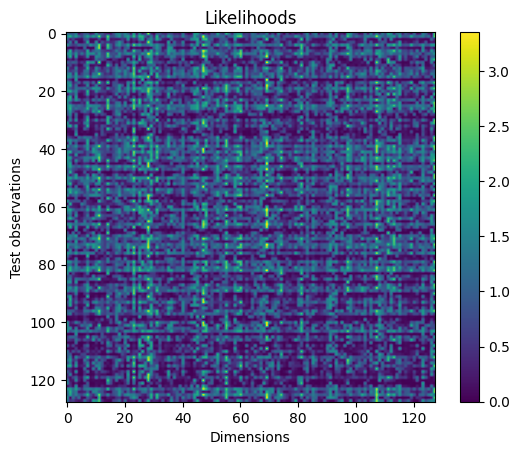

In [5]:
def plot_likelihoods(likelihoods):
  plt.title('Likelihoods')
  plt.imshow(likelihoods)
  plt.xlabel('Dimensions')
  plt.ylabel('Test observations')
  plt.colorbar()
  plt.show()

plot_likelihoods(likelihoods)

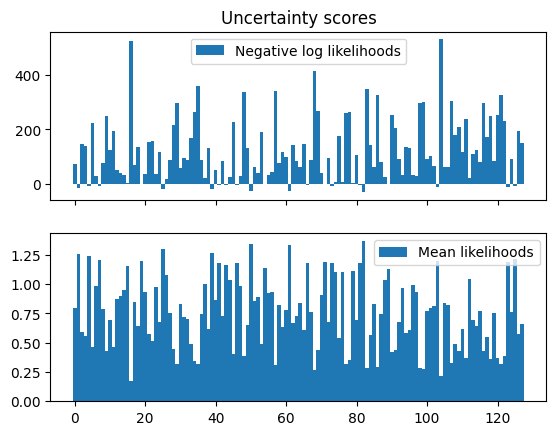

In [6]:
def mean_likelihood(likelihoods):
  return likelihoods.mean(1)

def log_likelihood(likelihoods):
  return np.log(likelihoods).sum(1)

def plot_likelihoods(ax, x, likelihoods, label):
  ax.bar(x, likelihoods, 1, label=label)
  ax.legend()

def plot_ue(likelihoods):
  log_likelihoods = log_likelihood(likelihoods)
  mean_likelihoods = mean_likelihood(likelihoods)

  fig, axes = plt.subplots(2, 1, sharex=True)
  x = range(likelihoods.shape[0])

  axes[0].set_title('Uncertainty scores')
  plot_likelihoods(axes[0], x, -log_likelihoods, 'Negative log likelihoods')
  plot_likelihoods(axes[1], x, mean_likelihoods, 'Mean likelihoods')
  plt.show()

plot_ue(likelihoods)